In [14]:
import os
import warnings
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Subsection 1.2.
import cftime
import datetime as dt
import xarray
from netCDF4 import Dataset, date2index, num2date, date2num

# Subsections 2.1. and 2.2.
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC, LinearSVC, SVR, LinearSVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import diagrams as diag

In [15]:
__author__ = 'Aleksandar Anžel'
__copyright__ = ''
__credits__ = ['Aleksandar Anžel', 'Georges Hattab']
__license__ = 'GNU General Public License v3.0'
__version__ = '1.0'
__maintainer__ = 'Aleksandar Anžel'
__email__ = 'aleksandar.anzel@uni-marburg.de'
__status__ = 'Dev'

# General description

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [16]:
# =============================================================================
# TODO: Adapt the whole pipeline to include additional datasets that either
# TODO: contain data for other timepoints, or bias data for ML models
# TODO: Instead of parsing one df_input I should pass list_df_inputs where
# TODO: If that list contains one df then nothing changes from the existing
# TODO: implementation. However, if it has more than one element, I have to
# TODO: check another parameter and see if other datasets are timepoints or
# TODO: ML bias. Then I deal with those datasets differently
# =============================================================================

In [17]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

path_root_data = os.path.join('..', 'Data')

INT_RANDOM_SEED = 42

In [66]:
def df_generate_new_timepoint(df_input):
    """
    df_generate_new_timepoint adds noise to each column of the input dataframe,
    thus creating a slightly modified version of that dataframe. This version
    can be considered a snapshot of a phenomenon in a different time point.
    
    Args:
        pd.DataFrame(): An input dataframe that contains models in columns.
    
    Returns:
        pd.DataFrame(): An output dataframe which comes from the procedure
        described above.
    """
    
    df_result = pd.DataFrame()
    int_len = df_input.shape[0]
    for string_one_column in df_input.columns:
        df_result[string_one_column] = df_input[
            string_one_column].to_numpy() + np.random.normal(0, 1, int_len)
    
    return df_result

# 1. Paper reconstruction
## 1.1. Anscombes Quartet

In [18]:
path_anscombes_quartet = os.path.join(
    path_root_data, 'Dataset_0', 'Anscombes_Quartet.csv')

df_anscombes_quartet = pd.read_csv(path_anscombes_quartet)
df_anscombes_quartet

,x1,y1,x2,y2,x3,y3,x4,y4
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47
5,14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04
6,6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25
7,4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50
8,12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56
9,7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91


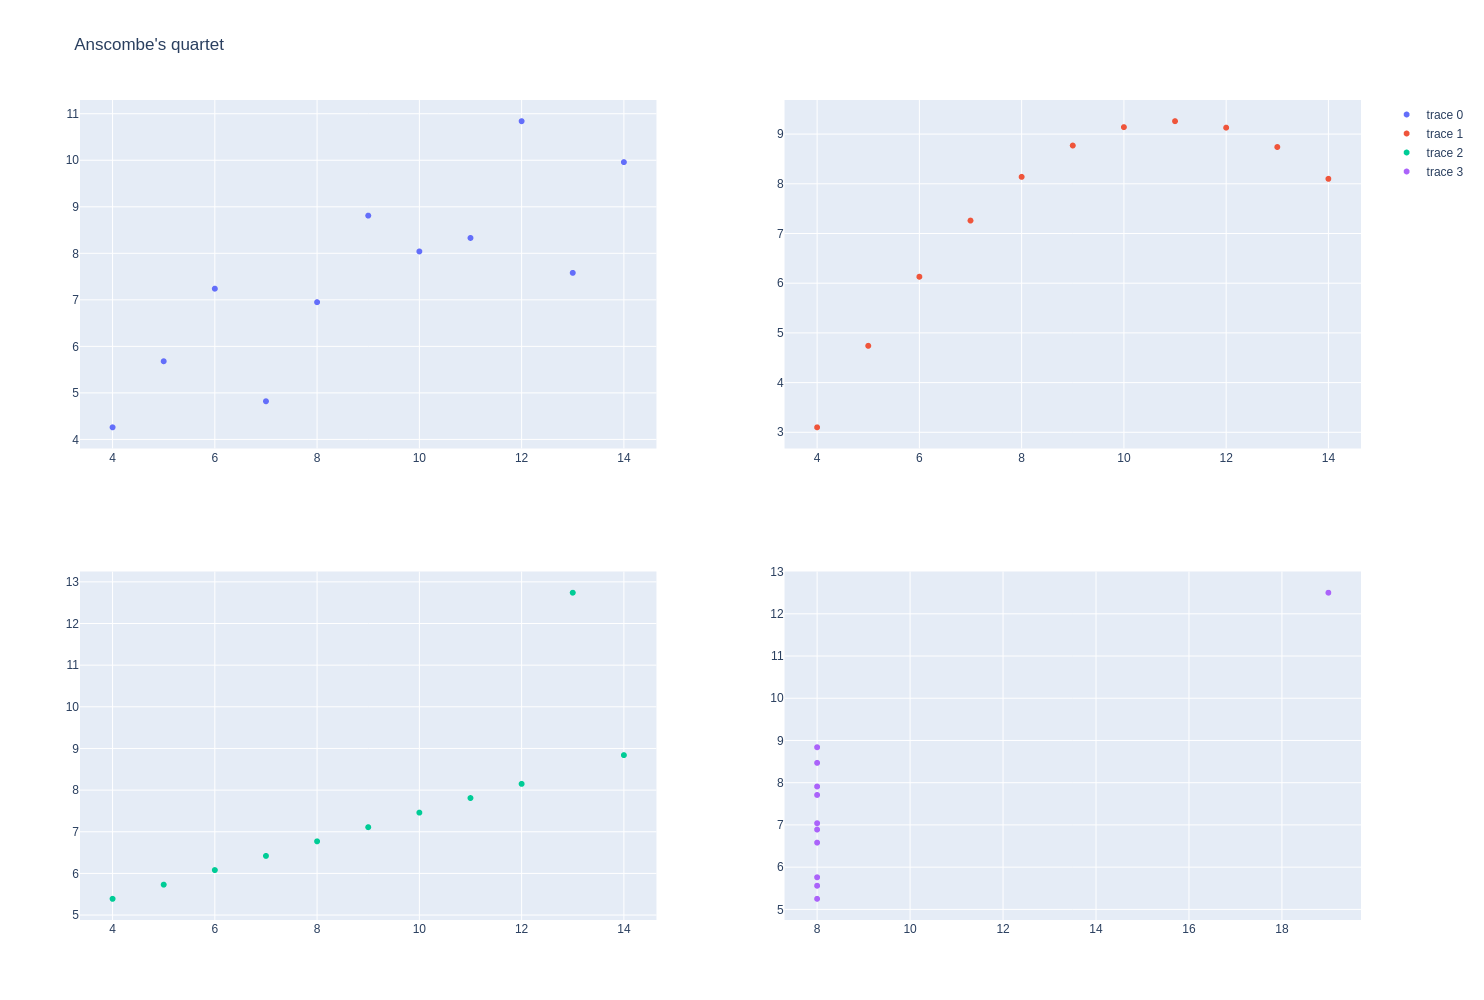

In [19]:
def chart_scatter_anscombes_quartet(df_input):
    
    chart_result = make_subplots(rows=2, cols=2)

    chart_result.add_trace(
        go.Scatter(x=df_input['x1'], y=df_input['y1'], mode="markers"),
        row=1, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x2'], y=df_input['y2'], mode="markers"),
        row=1, col=2
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x3'], y=df_input['y3'], mode="markers"),
        row=2, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x4'], y=df_input['y4'], mode="markers"),
        row=2, col=2
    )
    
    chart_result.update_layout(height=1000, title_text="Anscombe's quartet")
    
    return chart_result


chart_anscombes = chart_scatter_anscombes_quartet(df_anscombes_quartet)
chart_anscombes.show()
    

In [20]:
df_anscombes_quartet_modified = df_anscombes_quartet.drop(
    ['x1', 'x2', 'x3', 'x4'], axis=1)
df_anscombes_quartet_modified

,y1,y2,y3,y4
0,8.04,9.14,7.46,6.58
1,6.95,8.14,6.77,5.76
2,7.58,8.74,12.74,7.71
3,8.81,8.77,7.11,8.84
4,8.33,9.26,7.81,8.47
5,9.96,8.10,8.84,7.04
6,7.24,6.13,6.08,5.25
7,4.26,3.10,5.39,12.50
8,10.84,9.13,8.15,5.56
9,4.82,7.26,6.42,7.91


In [21]:
string_mid_type = 'scaled'
string_corr_method='pearson'

bool_discrete_anscombes = False

dict_mi_parameters_features_discrete_target_discrete = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=True,
    discrete_models=True,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_discrete_target_continous = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=False,
    discrete_models=True,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_continous_target_discrete = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=True,
    discrete_models=False,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_continous_target_continous = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=False,
    discrete_models=False,
    int_random_state=INT_RANDOM_SEED)

In [22]:
string_ref_model = 'y4'
df_taylor_res = diag.df_calculate_all_properties(df_anscombes_quartet_modified, string_ref_model, string_corr_method=string_corr_method, dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)
df_taylor_res

,Model,Standard Deviation,Correlation,Angle,RMS,Normalized_RMS,Normalized_STD,Entropy,Mutual Information,Fixed_MI,Scaled_entropy,Normalized MI,Angle_NMI,Joint_entropies,Scaled MI,Angle_SMI,Root Entropy
0,y1,1.937024,-0.489116,119.282510,3.342016,1.726176,1.000487,2.852820,0.000000,0.000000,1.052292,0.0,90.0,5.563874,0.0,180.0,1.689029
1,y2,1.937109,-0.478095,118.561047,3.329698,1.719814,1.000531,2.312211,0.000000,0.000000,0.852883,0.0,90.0,5.023265,0.0,180.0,1.520596
2,y3,1.935933,-0.155472,98.944159,2.943077,1.520121,0.999924,2.618974,0.000000,0.000000,0.966036,0.0,90.0,5.330028,0.0,180.0,1.618325
3,y4,1.936081,1.000000,0.000000,0.000000,0.000000,1.000000,2.711054,1.095635,2.711054,1.000000,1.0,0.0,2.711054,1.0,0.0,1.646528


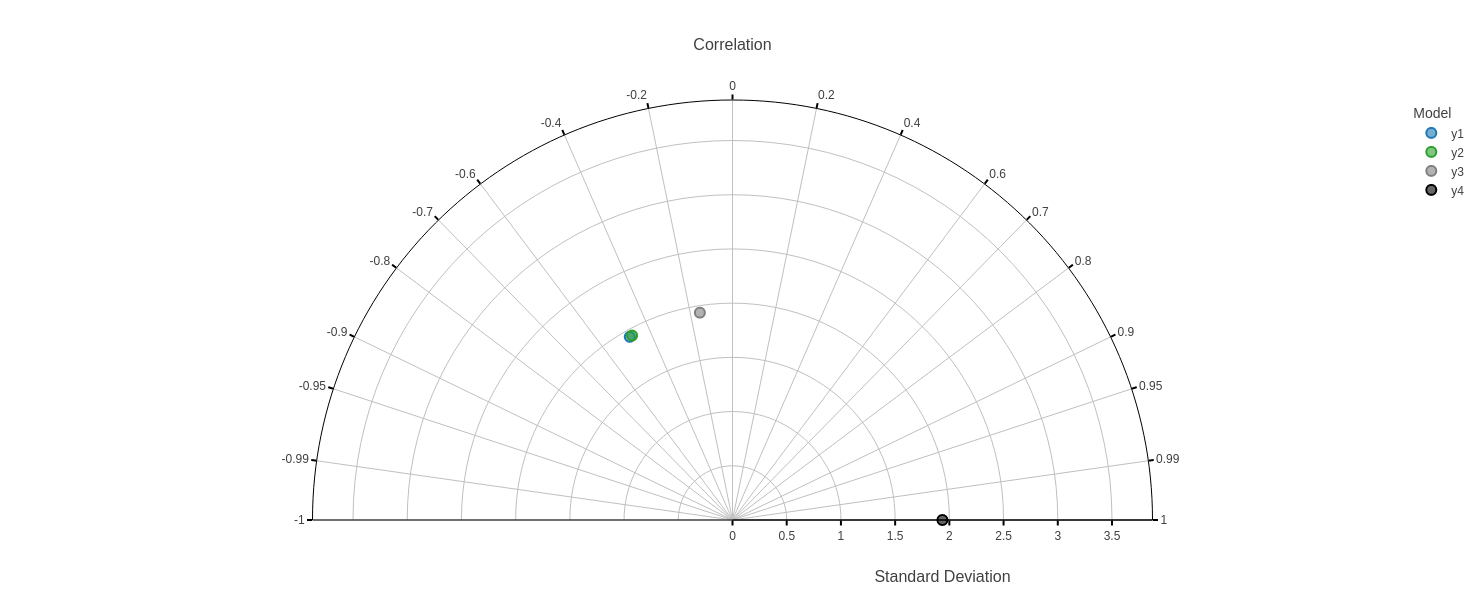

In [23]:
chart_taylor_res = diag.chart_create_taylor_diagram(df_anscombes_quartet_modified, string_ref_model, string_corr_method)
chart_taylor_res.show()

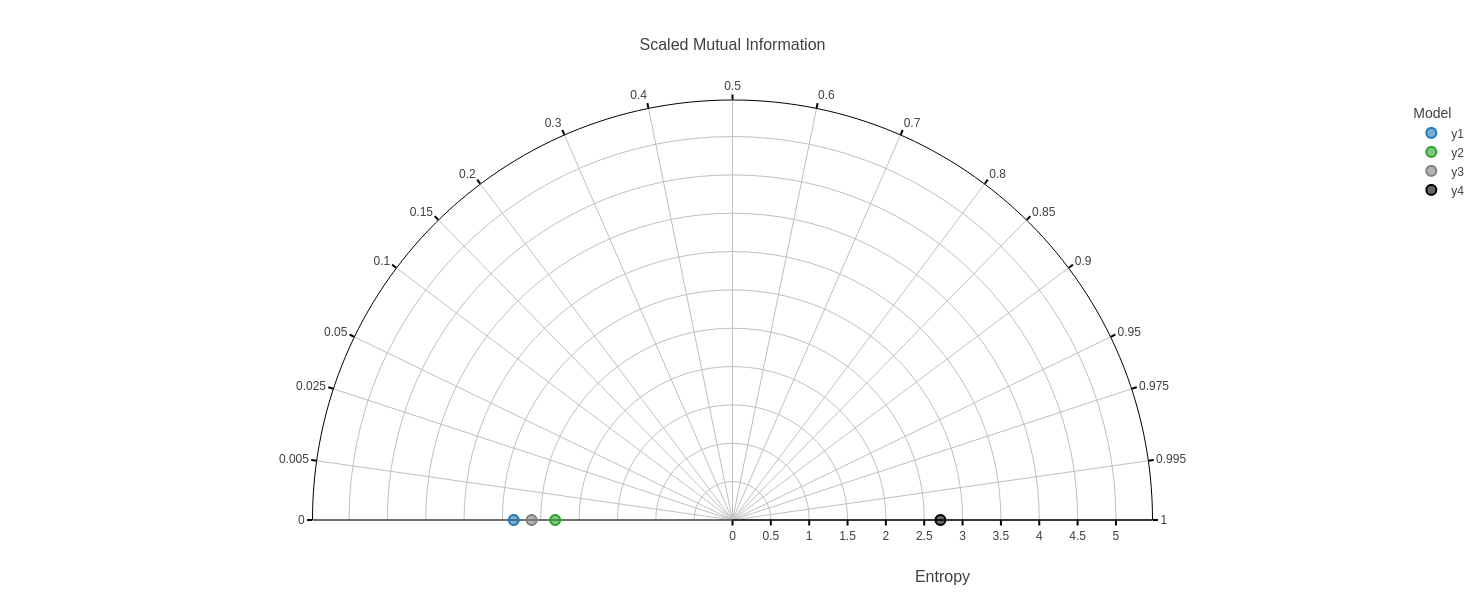

In [24]:
chart_taylor_res = diag.chart_create_mi_diagram(df_anscombes_quartet_modified, string_ref_model, string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_taylor_res.show()

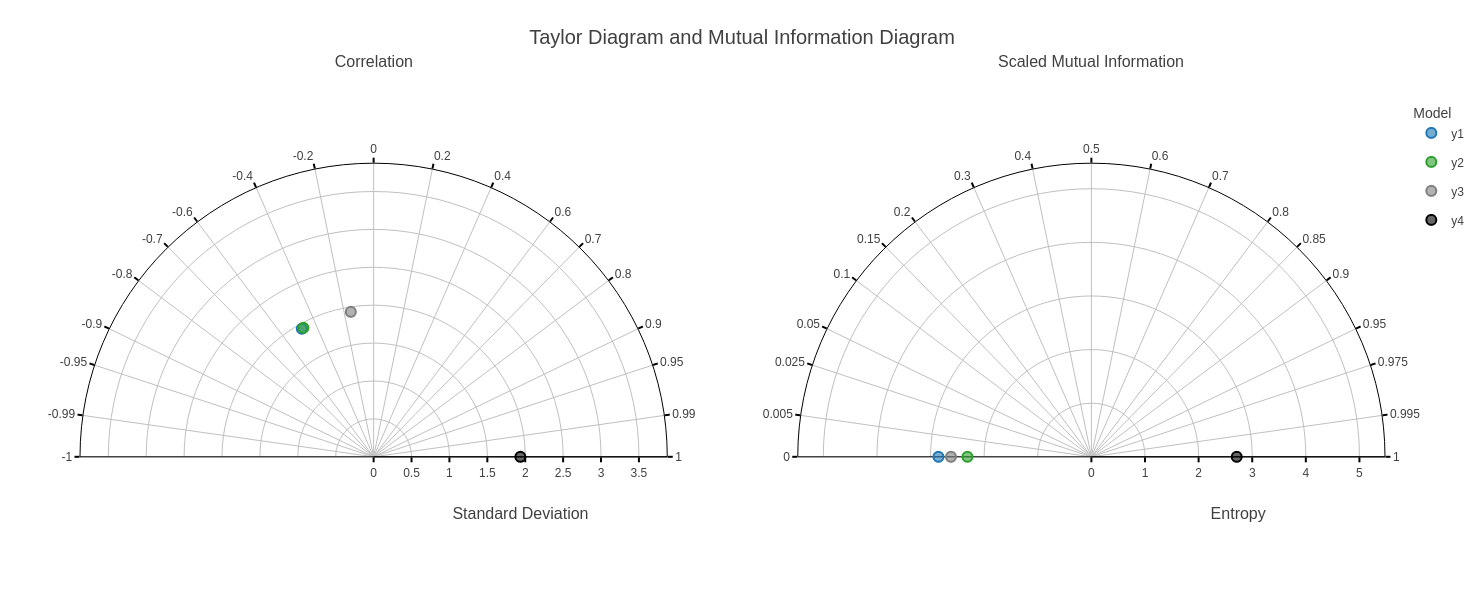

In [25]:
diag.chart_create_all_diagrams(df_anscombes_quartet_modified, string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

In [67]:
df_anscombes_quartet_modified_with_noise = df_generate_new_timepoint(df_anscombes_quartet_modified)
df_anscombes_quartet_modified_with_noise

,y1,y2,y3,y4
0,8.467017,7.740631,7.393510,5.106320
1,6.699730,6.994966,6.773362,6.292256
2,8.265180,9.754031,13.491736,6.993133
3,8.732626,7.499724,8.489671,7.803316
4,10.179782,8.207422,7.783562,10.184200
5,9.965129,7.793607,9.381766,8.973343
6,7.773633,5.910903,7.768905,5.804037
7,4.595629,2.191155,5.375459,12.140001
8,9.944637,7.564080,8.717195,6.493088
9,4.482091,6.570550,6.906576,7.907381


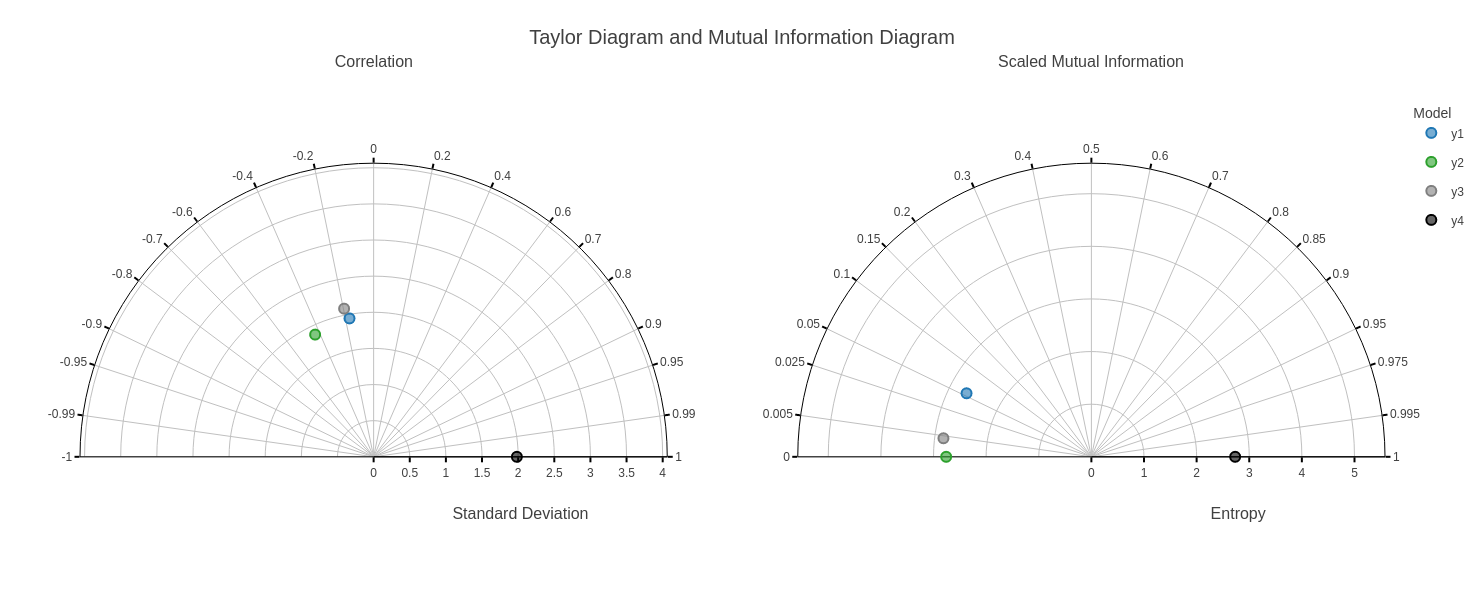

In [69]:
diag.chart_create_all_diagrams(df_anscombes_quartet_modified_with_noise, string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

## 1.2. CMIP3 Dataset - Historical Temperature Experiment

---

**IMPORTANT**
* How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
* Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts

---

In [30]:
def test_dataset_1():
    
    # IMPORTANT
    ###########################################################################
    # How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
    # Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts
    ###########################################################################
    path_dataset_1 = os.path.join(path_root_data, 'Dataset_1', 'Files')
    
    float_kelvin = 273.15
    
    list_datetimes = []
    list_temperatures = []
    list_models = []
    
    # Each name is encoded as a directory name
    list_model_names = [i for i in os.listdir(path_dataset_1)
                        if os.path.isdir(os.path.join(path_dataset_1, i))]
    
    for i, string_one_model in enumerate(list_model_names):
        path_one_model_dir = os.path.join(path_dataset_1, string_one_model)
        
        if string_one_model in ['ncar_ccsm3_0', 'mri_cgcm2_3_2a']:
            continue
        
        for j, string_one_model_file in enumerate(os.listdir(path_one_model_dir)):
        
            path_one_model_file = os.path.join(
                path_one_model_dir, string_one_model_file)
            
            ds_one_model_file = xarray.open_dataset(
                path_one_model_file, decode_times=True, use_cftime=True)
            
            try:
                # Time slicing for the 20th century
                ds_one_model_file_20th_century = ds_one_model_file.sel(
                    time=slice('1900-01-01','2000-01-01'))

                # Anual resampling
                ds_one_model_file_20th_century_mean = ds_one_model_file_20th_century.resample(time='AS').mean()

                ds_one_model_file_temperature = ds_one_model_file_20th_century_mean.variables['ts'].to_numpy()
                ds_one_model_file_time = ds_one_model_file_20th_century_mean.indexes['time'].to_datetimeindex()

                list_datetimes += ds_one_model_file_time.tolist()

                # Taking geographicall mean besides temporal
                np_tmp_temp = np.array(ds_one_model_file_temperature)
                list_geographically_mean_temperatures = np_tmp_temp.mean(axis=(1,2)).tolist()
                list_temperatures += list_geographically_mean_temperatures

                list_models += [string_one_model] * len(list_geographically_mean_temperatures)
            
            except:
                continue
    
    df_dataset_1 = pd.DataFrame(
        {'Datetime': list_datetimes, 'Temperature': list_temperatures,
         'Model': list_models})
    
    return df_dataset_1


df_dataset_1 = test_dataset_1()
df_dataset_1

/tmp/ipykernel_18331/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18331/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18331/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18331/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a 

,Datetime,Temperature,Model
0,1900-01-01,277.076477,inmcm3_0
1,1901-01-01,277.123596,inmcm3_0
2,1902-01-01,277.183899,inmcm3_0
3,1903-01-01,277.028564,inmcm3_0
4,1904-01-01,277.259094,inmcm3_0
...,...,...,...
2195,1995-01-01,277.791870,ukmo_hadcm3
2196,1996-01-01,277.680725,ukmo_hadcm3
2197,1997-01-01,277.992981,ukmo_hadcm3
2198,1998-01-01,277.921051,ukmo_hadcm3


In [31]:
df_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     2200 non-null   datetime64[ns]
 1   Temperature  2200 non-null   float64       
 2   Model        2200 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.7+ KB


In [32]:
df_dataset_1['Model'].unique()

array(['inmcm3_0', 'cccma_cgcm3_1_t63', 'ingv_echam4', 'iap_fgoals1_0_g',
       'miub_echo_g', 'giss_model_e_h', 'gfdl_cm2_1', 'giss_model_e_r',
       'bccr_bcm2_0', 'csiro_mk3_0', 'ukmo_hadgem1', 'gfdl_cm2_0',
       'mpi_echam5', 'miroc3_2_medres', 'ncar_pcm1', 'csiro_mk3_5',
       'giss_aom', 'miroc3_2_hires', 'ipsl_cm4', 'cccma_cgcm3_1',
       'cnrm_cm3', 'ukmo_hadcm3'], dtype=object)

In [33]:
len(df_dataset_1['Model'].unique())

22

In [ ]:
fig = px.line(df_dataset_1, x='Datetime', y='Temperature', color='Model',
              title='Global temperatures 20th century', render_mode='svg',
              line_shape='spline',
              color_discrete_sequence=px.colors.qualitative.Light24,)
fig.update_layout(height=1000)
fig.show()

In [ ]:
df_dataset_1_pivoted = pd.pivot(df_dataset_1, index=['Datetime'], columns=['Model'], values=['Temperature']).reset_index(drop=True)
df_dataset_1_pivoted.columns = df_dataset_1_pivoted.columns.get_level_values(1)
df_dataset_1_pivoted

In [ ]:
df_dataset_1_mid = diag.df_calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', dict_mi_parameters_features_continous_target_continous)
df_dataset_1_mid

In [ ]:
chart_mi_res = diag.chart_create_mi_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_mi_res.show()

In [ ]:
df_dataset_1_mid = diag.df_calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', dict_mi_parameters_features_continous_target_continous)
df_dataset_1_mid

In [ ]:
chart_mi_res = diag.chart_create_mi_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_mi_res.show()

In [ ]:
df_dataset_1_td = diag.df_calculate_td_properties (df_dataset_1_pivoted, 'bccr_bcm2_0')
df_dataset_1_td

In [ ]:
chart_td_res = diag.chart_create_taylor_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_corr_method)
chart_td_res.show()

In [ ]:
diag.chart_create_all_diagrams(df_dataset_1_pivoted, string_reference_model='bccr_bcm2_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

---
### TODO: Add one important comment that describes how two-datasets parsing funcitonality could also be used to evaluate performance of climate models between two runs. One dataset could come from the first run, and the second one from the second run. 

---

# 2. Additional datasets (not present in the original paper)
## 2.1. Datasets with discrete reference features

In [ ]:
df_iris = datasets.load_iris(as_frame=True, return_X_y=True)
df_iris = pd.concat([df_iris[0], df_iris[1]], axis=1)
df_iris

In [ ]:
# The original Breast Cancer Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29

##  Attribute                     Domain
#   -- -----------------------------------------
#   1. Sample code number            id number
#   2. Clump Thickness               1 - 10
#   3. Uniformity of Cell Size       1 - 10
#   4. Uniformity of Cell Shape      1 - 10
#   5. Marginal Adhesion             1 - 10
#   6. Single Epithelial Cell Size   1 - 10
#   7. Bare Nuclei                   1 - 10
#   8. Bland Chromatin               1 - 10
#   9. Normal Nucleoli               1 - 10
#  10. Mitoses                       1 - 10
#  11. Class:                        (2 for benign, 4 for malignant)

path_breast_cancer = os.path.join(path_root_data, 'Dataset_2',
                                  'Breast_Cancer_Wisconsin_Original',
                                  'breast-cancer-wisconsin.data')

df_breast_cancer = pd.read_csv(path_breast_cancer, header=None, na_values=['?'])
df_breast_cancer.dropna(inplace=True)
df_breast_cancer.drop([0], axis=1, inplace=True)
np_breast_cancer_ground_truth = df_breast_cancer[10].to_numpy()
df_breast_cancer

In [ ]:
# The original E. Coli Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/ecoli

##  Attribute Information:
#   -- -----------------------------------------
#  1.  Sequence Name: Accession number for the SWISS-PROT database
#  2.  mcg: McGeoch's method for signal sequence recognition.
#  3.  gvh: von Heijne's method for signal sequence recognition.
#  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
#           Binary attribute.
#  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
#	   Binary attribute.
#  6.  aac: score of discriminant analysis of the amino acid content of
#	   outer membrane and periplasmic proteins.
#  7. alm1: score of the ALOM membrane spanning region prediction program.
#  8. alm2: score of ALOM program after excluding putative cleavable signal
#	   regions from the sequence.

path_ecoli = os.path.join(path_root_data, 'Dataset_2', 'E_Coli', 'ecoli.data')

df_ecoli = pd.read_csv(path_ecoli, header=None, delim_whitespace=True)
df_ecoli.drop([0], axis=1, inplace=True)
df_ecoli[df_ecoli.columns[-1]] = pd.factorize(df_ecoli[df_ecoli.columns[-1]])[0]
df_ecoli

In [ ]:
# The original Glass Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/glass+identification

#   Attribute Information:
#   -- -----------------------------------------
#   1. Id number: 1 to 214
#   2. RI: refractive index
#   3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as 
#                  are attributes 4-10)
#   4. Mg: Magnesium
#   5. Al: Aluminum
#   6. Si: Silicon
#   7. K: Potassium
#   8. Ca: Calcium
#   9. Ba: Barium
#  10. Fe: Iron
#  11. Type of glass: (class attribute)
#      -- 1 building_windows_float_processed
#      -- 2 building_windows_non_float_processed
#      -- 3 vehicle_windows_float_processed
#      -- 4 vehicle_windows_non_float_processed (none in this database)
#      -- 5 containers
#      -- 6 tableware
#      -- 7 headlamps

path_glass = os.path.join(path_root_data, 'Dataset_2', 'Glass', 'glass.data')

df_glass = pd.read_csv(path_glass, header=None)
df_glass.drop([0], axis=1, inplace=True)
np_glass_ground_truth = df_glass[10].to_numpy()
df_glass

In [ ]:
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
# List of classifiers comes from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html # noqa
# This list was adapted by adding more models

# IDEA: The diagram could be used to visualize the results of GridSearchCV
# IDEA: since this function already fits multiple models and predicts the data

list_classification_models = [
    ('KNN', KNeighborsClassifier()),
    ('SVM_Linear', LinearSVC()),
    ('SVM_Gaussian', SVC(kernel='rbf')),
    ('Gaussian_PC', GaussianProcessClassifier()),
    ('Decision_Tree_C', DecisionTreeClassifier()),
    ('Random_Forest_C', RandomForestClassifier()),
    ('MLPC', MLPClassifier()),
    ('Ada_Boost_C', AdaBoostClassifier()),
    ('Gaussian_NB', GaussianNB()),
    ('Quadratic_DA', QuadraticDiscriminantAnalysis()),
    ('Gradient_BC', GradientBoostingClassifier()),
    ('SGDC', SGDClassifier())]

list_regression_models = [
    ('KNN', KNeighborsRegressor()),
    ('SVM_Linear', LinearSVR()),
    ('SVM_Gaussian', SVR(kernel='rbf')),
    ('Gaussian_PR', GaussianProcessRegressor()),
    ('Decision_Tree_R', DecisionTreeRegressor()),
    ('Random_Forest_R', RandomForestRegressor()),
    ('MLPR', MLPRegressor()),
    ('Ada_Boost_R', AdaBoostRegressor()),
    ('Gradient_BR', GradientBoostingRegressor()),
    ('SGDR', SGDRegressor())]


def tuple_preprocess_dataset(np_x, np_y):
    
    np_x_train, np_x_test, np_y_train, np_y_test = train_test_split(
        np_x, np_y, test_size=0.33, random_state=INT_RANDOM_SEED)
    
    constructor_scaler = StandardScaler()
    np_scaled_x_train = constructor_scaler.fit_transform(np_x_train)
    np_scaled_x_test = constructor_scaler.transform(np_x_test)
    
    return np_scaled_x_train, np_scaled_x_test, np_y_train, np_y_test


def df_fit_all_models(df_input, list_models, bool_is_classification=True):
    np_x = df_input[df_input.columns[:-1]].to_numpy()
    np_y = df_input[df_input.columns[-1]].to_numpy()

    np_x_train, np_x_test, np_y_train, np_y_test = tuple_preprocess_dataset(
        np_x, np_y)    


    list_scoring = ['accuracy', 'precision_weighted', 'recall_weighted',
                    'f1_weighted', 'roc_auc']

    df_result = pd.DataFrame()
    df_result['Ground_Truth'] = np_y_test

    for string_model_name, constructor_one_model in list_models:
        
        if bool_is_classification is True:
            constructor_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                                random_state=INT_RANDOM_SEED)
            cv_results = cross_validate(
                constructor_one_model, np_x_train, np_y_train,
                cv=constructor_kfold, scoring=list_scoring)

        model_tmp = constructor_one_model.fit(np_x_train, np_y_train)
        np_y_pred = model_tmp.predict(np_x_test)

        df_result[string_model_name] = np_y_pred

    return df_result


def list_evaluate_all_datasets(list_of_datasets, list_models, bool_is_classification=True):
    list_df_results = []
    
    for df_tmp in list_of_datasets:
        list_df_results.append(df_fit_all_models(
            df_tmp, list_models, bool_is_classification))
    
    return list_df_results


In [ ]:
list_datasets = [df_iris, df_glass, df_breast_cancer, df_ecoli]
list_results = list_evaluate_all_datasets(
    list_datasets, list_classification_models, bool_is_classification=True)

### 2.1.1. Dataset - Iris

In [ ]:
list_results[0].head()

In [ ]:
diag.chart_create_all_diagrams(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.2. Dataset - Glass

In [ ]:
diag.chart_create_all_diagrams(list_results[1], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.3. Dataset - Breast Cancer

In [ ]:
diag.chart_create_all_diagrams(list_results[2], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.4. Dataset - E. Coli

In [ ]:
diag.chart_create_all_diagrams(list_results[3], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

## 2.2. Datasets with continous reference features

In [ ]:
df_california = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
df_california = pd.concat([df_california[0], df_california[1]], axis=1)
df_california.dropna(inplace=True)
df_california

In [ ]:
df_ames = datasets.fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
df_ames = pd.concat([df_ames[0], df_ames[1]], axis=1)
df_ames.dropna(inplace=True, axis=1)  # We delete columns, not rows as above
list_categorical_columns = df_ames.dtypes.pipe(lambda x: x[x == 'object']).index

for string_one_columd in list_categorical_columns:
    df_ames[string_one_columd] = pd.factorize(df_ames[string_one_columd])[0]

df_ames

In [ ]:
list_datasets = [df_california, df_ames]
list_results = list_evaluate_all_datasets(
    list_datasets, list_regression_models, bool_is_classification=False)

### 2.2.1. Dataset - California Housing

In [ ]:
list_results[0].head()

In [ ]:
df_california_properties = diag.df_calculate_all_properties(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)
df_california_properties

In [ ]:
diag.chart_create_all_diagrams(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

### 2.2.2. Dataset - Ames Housing

In [ ]:
diag.chart_create_all_diagrams(list_results[1], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

## 2.3. Biological/Medical model/patient comparison

In [ ]:
# The original HCV Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/HCV+data

#   Attribute Information:
#   -- -----------------------------------------
#   All attributes except Category and Sex are numerical. The laboratory data are the attributes 5-14.
# 1) X (Patient ID/No.)
# 2) Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
# 3) Age (in years)
# 4) Sex (f,m)
# 5) ALB
# 6) ALP
# 7) ALT
# 8) AST
# 9) BIL
# 10) CHE
# 11) CHOL
# 12) CREA
# 13) GGT
# 14) PROT 

path_hcv = os.path.join(path_root_data, 'Dataset_3', 'hcvdat0.csv')

df_hcv = pd.read_csv(path_hcv)
df_hcv.drop(['Unnamed: 0'], axis=1, inplace=True)
df_hcv.dropna(inplace=True)
df_hepatitis_patients = df_hcv[df_hcv['Category'] == '1=Hepatitis']
df_hepatitis_patients = df_hepatitis_patients.drop(
    ['Category', 'Age', 'Sex'], axis=1).reset_index(drop=True)
df_hepatitis_patients['Patient'] = ['Patient_' + str(i) for i in
                                  range(df_hepatitis_patients.shape[0])]
df_hepatitis_patients_pivoted = df_hepatitis_patients.pivot_table(
    columns='Patient')
df_hepatitis_patients_pivoted = df_hepatitis_patients_pivoted[
    ['Patient_' + str(i) for i in range(df_hepatitis_patients.shape[0])]]
df_hepatitis_patients_pivoted

### 2.3.1. Dataset - Hepatitis

In [ ]:
diag.chart_create_all_diagrams(df_hepatitis_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

In [ ]:
# The original Fertility Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/Fertility

#   Attribute Information:
#   -- -----------------------------------------
# Season in which the analysis was performed. 1) winter, 2) spring, 3) Summer, 4) fall. (-1, -0.33, 0.33, 1)
# Age at the time of analysis. 18-36 (0, 1)
# Childish diseases (ie , chicken pox, measles, mumps, polio) 1) yes, 2) no. (0, 1)
# Accident or serious trauma 1) yes, 2) no. (0, 1)
# Surgical intervention 1) yes, 2) no. (0, 1)
# High fevers in the last year 1) less than three months ago, 2) more than three months ago, 3) no. (-1, 0, 1)
# Frequency of alcohol consumption 1) several times a day, 2) every day, 3) several times a week, 4) once a week, 5) hardly ever or never (0, 1)
# Smoking habit 1) never, 2) occasional 3) daily. (-1, 0, 1)
# Number of hours spent sitting per day ene-16 (0, 1)
# Output: Diagnosis normal (N), altered (O) 

path_fertility = os.path.join(path_root_data, 'Dataset_3', 'fertility_Diagnosis.txt')

df_fertility = pd.read_csv(path_fertility, header=None)
df_fertility.dropna(inplace=True)
df_fertility_patients = df_fertility[df_fertility[9] == 'O']
df_fertility_patients = df_fertility_patients.drop([9], axis=1).reset_index(
    drop=True)
df_fertility_patients['Patient'] = ['Patient_' + str(i) for i in
                                  range(df_fertility_patients.shape[0])]
df_fertility_patients_pivoted = df_fertility_patients.pivot_table(
    columns='Patient')
df_fertility_patients_pivoted = df_fertility_patients_pivoted[
    ['Patient_' + str(i) for i in range(df_fertility_patients.shape[0])]]

for string_column in df_fertility_patients_pivoted.columns:
    df_fertility_patients_pivoted[string_column] = pd.factorize(df_fertility_patients_pivoted[string_column])[0]

df_fertility_patients_pivoted

### 2.3.2. Dataset - Fertility

In [ ]:
diag.df_calculate_all_properties(df_fertility_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

In [ ]:
diag.chart_create_all_diagrams(df_fertility_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)